# 🧹 Nettoyage des Données Capteurs

**Objectif** : Nettoyer et préparer le dataset capteurs pour l'entraînement ML

**Dataset** : `data/raw/capteurs/data/full_dataset.csv`

**Étapes** :
1. Charger les données
2. Explorer la structure
3. Transformer format (long → large)
4. Nettoyer valeurs aberrantes
5. Gérer valeurs manquantes
6. Calculer score qualité
7. Sauvegarder dataset propre

## 📦 1. Importer les bibliothèques

**Pourquoi chaque bibliothèque ?**
- `pandas` : Manipuler les tableaux de données (CSV)
- `numpy` : Calculs mathématiques
- `matplotlib` : Créer des graphiques
- `seaborn` : Graphiques plus jolis

In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuration pour de beaux graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Afficher toutes les colonnes (pas de troncature)
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées avec succès !")

✅ Bibliothèques importées avec succès !


## 📂 2. Charger les données

**Format actuel** : Format "long" (1 ligne = 1 mesure d'1 indicateur)

**Colonnes** :
- `MonitoringLocationIdentifier` : ID de la station
- `LongitudeMeasure_WGS84` : Longitude GPS
- `LatitudeMeasure_WGS84` : Latitude GPS
- `MonitoringDate` : Date de la mesure
- `IndicatorsName` : Nom du paramètre (pH, TEMP, DO...)
- `Value` : Valeur mesurée
- `Unit` : Unité de mesure

In [2]:
# Charger le dataset (peut prendre 10-20 secondes)
print("📥 Chargement du dataset...")

df_raw = pd.read_csv('../data/raw/capteurs/full_dataset.csv', low_memory=False)

print(f"✅ Dataset chargé : {len(df_raw):,} lignes")
print(f"📊 Colonnes : {df_raw.columns.tolist()}")
print(f"📁 Taille mémoire : {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📥 Chargement du dataset...
✅ Dataset chargé : 336,293 lignes
📊 Colonnes : ['MonitoringLocationIdentifier', 'LongitudeMeasure_WGS84', 'LatitudeMeasure_WGS84', 'MonitoringDate', 'IndicatorsName', 'Value', 'Unit', 'SourceProvider']
📁 Taille mémoire : 110.17 MB
✅ Dataset chargé : 336,293 lignes
📊 Colonnes : ['MonitoringLocationIdentifier', 'LongitudeMeasure_WGS84', 'LatitudeMeasure_WGS84', 'MonitoringDate', 'IndicatorsName', 'Value', 'Unit', 'SourceProvider']
📁 Taille mémoire : 110.17 MB


## 🔍 3. Explorer les données

**Questions à répondre** :
- Combien d'indicateurs différents ?
- Combien de mesures par indicateur ?
- Quelles stations ?
- Quelle période ?

In [3]:
# Afficher les premières lignes pour comprendre la structure
print("📋 APERÇU DES DONNÉES (5 premières lignes) :")
print("="*80)
df_raw.head()

📋 APERÇU DES DONNÉES (5 premières lignes) :


,MonitoringLocationIdentifier,LongitudeMeasure_WGS84,LatitudeMeasure_WGS84,MonitoringDate,IndicatorsName,Value,Unit,SourceProvider
0,1,80.666649,43.838487,2012-05-28,NH4N,0.07,mg/l,China National Environmental Monitoring Centre...
1,1,80.666649,43.838487,2012-05-28,CODMn,2.9,mg/l,China National Environmental Monitoring Centre...
2,1,80.666649,43.838487,2012-05-28,DO,6.04,mg/l,China National Environmental Monitoring Centre...
3,1,80.666649,43.838487,2012-05-28,pH,7.9,pH,China National Environmental Monitoring Centre...
4,1,80.666649,43.838487,2012-06-04,NH4N,0.04,mg/l,China National Environmental Monitoring Centre...


📊 STATISTIQUES GÉNÉRALES :
Nombre de lignes : 336,293
Nombre de colonnes : 8
Nombre de stations : 2,384
Période : 1980-01-07 → 2022-08-01

🧪 INDICATEURS DISPONIBLES :
IndicatorsName
pH       74458
DO       73007
NH4N     54502
CODMn    54379
COD      19602
DIP      19378
DIN      19369
TPH      19338
TEMP       520
BOD        432
NO3N       388
NO2N       334
TSSs       329
TP         196
DOSAT       31
TDP         16
DOC         13
TOC          1
Name: count, dtype: int64



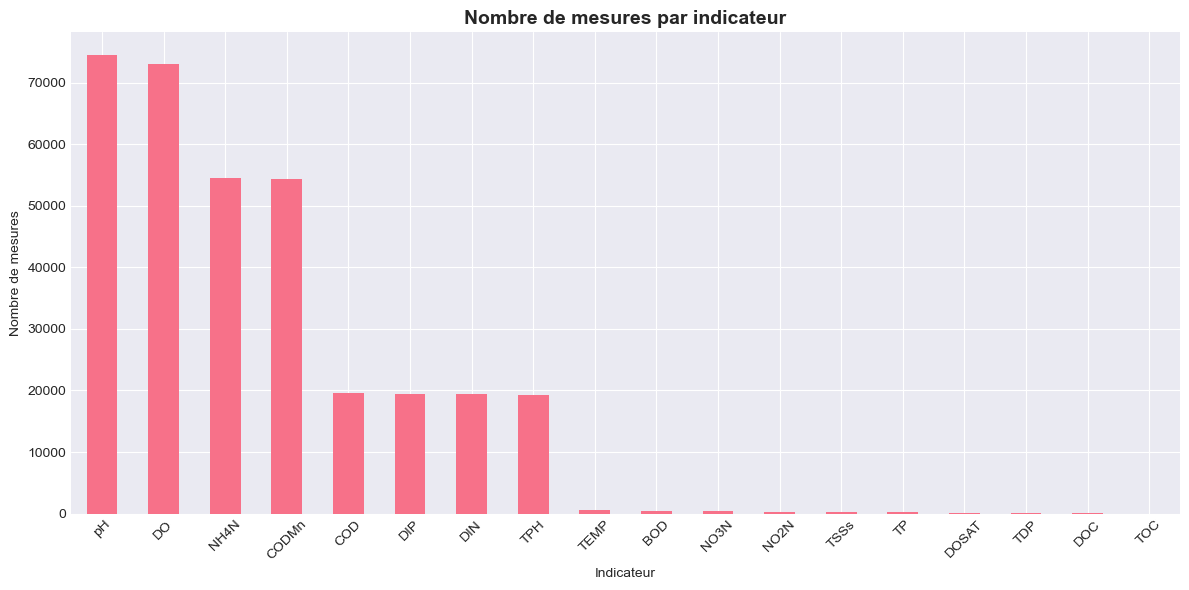

In [4]:
# Statistiques générales
print("📊 STATISTIQUES GÉNÉRALES :")
print("="*80)
print(f"Nombre de lignes : {len(df_raw):,}")
print(f"Nombre de colonnes : {len(df_raw.columns)}")
print(f"Nombre de stations : {df_raw['MonitoringLocationIdentifier'].nunique():,}")
print(f"Période : {df_raw['MonitoringDate'].min()} → {df_raw['MonitoringDate'].max()}")
print()

# Compter les indicateurs disponibles
print("🧪 INDICATEURS DISPONIBLES :")
print("="*80)
indicator_counts = df_raw['IndicatorsName'].value_counts()
print(indicator_counts)
print()

# Graphique des indicateurs
plt.figure(figsize=(12, 6))
indicator_counts.plot(kind='bar')
plt.title('Nombre de mesures par indicateur', fontsize=14, fontweight='bold')
plt.xlabel('Indicateur')
plt.ylabel('Nombre de mesures')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🔄 4. Transformer en format "large"

**Pourquoi ?** Le modèle ML a besoin d'avoir tous les paramètres sur la même ligne.

**Format actuel (long)** :
```
Station | Date       | Indicateur | Valeur
1       | 2020-01-01 | pH         | 7.5
1       | 2020-01-01 | TEMP       | 15.2
1       | 2020-01-01 | DO         | 8.3
```

**Format souhaité (large)** :
```
Station | Date       | pH  | TEMP | DO
1       | 2020-01-01 | 7.5 | 15.2 | 8.3
```

In [6]:
print("🔄 Transformation format long → large...")
print("Cela peut prendre 1-2 minutes...")
print()

# IMPORTANT : Convertir la colonne Value en numérique
# Certaines valeurs peuvent être du texte → convertir en NaN
print("🔧 Conversion des valeurs en numérique...")
df_raw['Value'] = pd.to_numeric(df_raw['Value'], errors='coerce')
# 'coerce' = si impossible de convertir en nombre → mettre NaN

# Vérifier combien de valeurs non-numériques ont été converties en NaN
non_numeric = df_raw['Value'].isnull().sum()
print(f"  → {non_numeric:,} valeurs non-numériques converties en NaN")
print()

# Pivoter le dataframe
# pivot_table = transformer colonnes en lignes
# index = colonnes qui restent fixes
# columns = colonne à transformer en colonnes
# values = valeurs à mettre dans les nouvelles colonnes
# aggfunc = si plusieurs valeurs pour une même combinaison, prendre la moyenne

df_wide = df_raw.pivot_table(
    index=['MonitoringLocationIdentifier', 
           'LongitudeMeasure_WGS84', 
           'LatitudeMeasure_WGS84', 
           'MonitoringDate'],
    columns='IndicatorsName',
    values='Value',
    aggfunc='mean'  # Si plusieurs mesures le même jour, prendre la moyenne
).reset_index()

print(f"✅ Transformation terminée !")
print(f"📊 Nouveau format : {len(df_wide):,} lignes × {len(df_wide.columns)} colonnes")
print()

# Renommer colonnes pour plus de clarté
df_wide = df_wide.rename(columns={
    'MonitoringLocationIdentifier': 'station_id',
    'LongitudeMeasure_WGS84': 'longitude',
    'LatitudeMeasure_WGS84': 'latitude',
    'MonitoringDate': 'date',
    'TEMP': 'temperature',
    'DO': 'oxygene_dissous',
    'TSSs': 'turbidite'
})

print("✅ Colonnes renommées en français")
print()

# Afficher aperçu
print("📋 APERÇU FORMAT LARGE :")
print("="*80)
df_wide.head()

🔄 Transformation format long → large...
Cela peut prendre 1-2 minutes...

🔧 Conversion des valeurs en numérique...
  → 3,486 valeurs non-numériques converties en NaN

✅ Transformation terminée !
📊 Nouveau format : 75,747 lignes × 22 colonnes

✅ Colonnes renommées en français

📋 APERÇU FORMAT LARGE :
✅ Transformation terminée !
📊 Nouveau format : 75,747 lignes × 22 colonnes

✅ Colonnes renommées en français

📋 APERÇU FORMAT LARGE :


IndicatorsName,station_id,longitude,latitude,date,BOD,COD,CODMn,DIN,DIP,oxygene_dissous,DOC,DOSAT,NH4N,NO2N,NO3N,TDP,temperature,TOC,TP,TPH,turbidite,pH
0,1,80.666649,43.838487,2012-05-28,NaN,NaN,2.9,NaN,NaN,6.04,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9
1,1,80.666649,43.838487,2012-06-04,NaN,NaN,2.7,NaN,NaN,6.62,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8
2,1,80.666649,43.838487,2012-06-11,NaN,NaN,1.0,NaN,NaN,6.39,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8
3,1,80.666649,43.838487,2012-06-18,NaN,NaN,1.3,NaN,NaN,5.60,NaN,NaN,1.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7
4,1,80.666649,43.838487,2012-06-25,NaN,NaN,3.0,NaN,NaN,4.63,NaN,NaN,2.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7


In [7]:
# Vérifier quelles colonnes sont disponibles maintenant
print("📋 COLONNES DISPONIBLES APRÈS PIVOT :")
print("="*80)
for i, col in enumerate(df_wide.columns, 1):
    print(f"{i:2d}. {col}")

📋 COLONNES DISPONIBLES APRÈS PIVOT :
 1. station_id
 2. longitude
 3. latitude
 4. date
 5. BOD
 6. COD
 7. CODMn
 8. DIN
 9. DIP
10. oxygene_dissous
11. DOC
12. DOSAT
13. NH4N
14. NO2N
15. NO3N
16. TDP
17. temperature
18. TOC
19. TP
20. TPH
21. turbidite
22. pH


## 🔍 5. Analyser les valeurs manquantes

**Problème** : Toutes les stations n'ont pas mesuré tous les paramètres.

**Solution** : Identifier et décider quoi faire.

🔍 VALEURS MANQUANTES PAR COLONNE :
        Colonne  Manquantes  Pourcentage
            TOC       75746    99.998680
            DOC       75734    99.982838
            TDP       75731    99.978877
          DOSAT       75716    99.959074
             TP       75551    99.741244
      turbidite       75418    99.565659
           NO2N       75413    99.559058
           NO3N       75359    99.487768
            BOD       75315    99.429680
    temperature       75227    99.313504
            TPH       58862    77.708688
            DIP       57308    75.657122
            DIN       56378    74.429350
            COD       56239    74.245845
          CODMn       21368    28.209698
           NH4N       21245    28.047315
oxygene_dissous        2740     3.617305
             pH        1289     1.701718



<Figure size 1200x600 with 0 Axes>

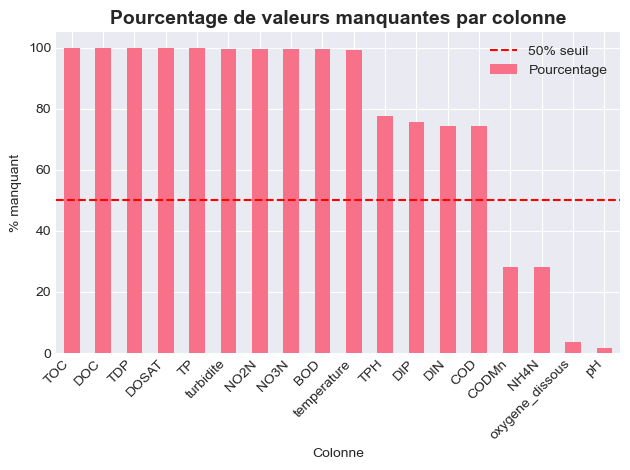

In [8]:
# Compter valeurs manquantes par colonne
print("🔍 VALEURS MANQUANTES PAR COLONNE :")
print("="*80)

missing = df_wide.isnull().sum()
missing_percent = (missing / len(df_wide)) * 100

# Créer tableau récapitulatif
missing_df = pd.DataFrame({
    'Colonne': missing.index,
    'Manquantes': missing.values,
    'Pourcentage': missing_percent.values
}).sort_values('Pourcentage', ascending=False)

# Afficher seulement colonnes avec valeurs manquantes
missing_df_filtered = missing_df[missing_df['Manquantes'] > 0]
print(missing_df_filtered.to_string(index=False))
print()

# Graphique
plt.figure(figsize=(12, 6))
missing_df_filtered.plot(x='Colonne', y='Pourcentage', kind='bar', legend=False)
plt.title('Pourcentage de valeurs manquantes par colonne', fontsize=14, fontweight='bold')
plt.xlabel('Colonne')
plt.ylabel('% manquant')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=50, color='r', linestyle='--', label='50% seuil')
plt.legend()
plt.tight_layout()
plt.show()

## ✂️ 6. Sélectionner les colonnes importantes

**Stratégie** : Garder seulement les paramètres avec peu de valeurs manquantes (<80%)

**Colonnes prioritaires pour le modèle** :
- `pH` : Acidité (important)
- `temperature` : Température eau
- `oxygene_dissous` (DO) : Oxygène
- `turbidite` (TSSs) : Turbidité
- **Bonus** : COD, CODMn, NH4N (si disponibles)

In [9]:
# Sélectionner colonnes avec <80% de valeurs manquantes
threshold = 80  # Pourcentage maximum acceptable

# Identifier colonnes à garder
cols_to_keep = missing_df[missing_df['Pourcentage'] < threshold]['Colonne'].tolist()

# Toujours garder les colonnes de base
base_cols = ['station_id', 'longitude', 'latitude', 'date']
for col in base_cols:
    if col not in cols_to_keep:
        cols_to_keep.insert(0, col)

# Filtrer dataframe
df_clean = df_wide[cols_to_keep].copy()

print(f"✅ Colonnes conservées : {len(cols_to_keep)}")
print(f"📊 Dataset filtré : {len(df_clean):,} lignes × {len(df_clean.columns)} colonnes")
print()
print("📋 COLONNES CONSERVÉES :")
for i, col in enumerate(cols_to_keep, 1):
    missing_pct = (df_clean[col].isnull().sum() / len(df_clean)) * 100
    print(f"{i:2d}. {col:25s} → {missing_pct:5.1f}% manquant")

✅ Colonnes conservées : 12
📊 Dataset filtré : 75,747 lignes × 12 colonnes

📋 COLONNES CONSERVÉES :
 1. TPH                       →  77.7% manquant
 2. DIP                       →  75.7% manquant
 3. DIN                       →  74.4% manquant
 4. COD                       →  74.2% manquant
 5. CODMn                     →  28.2% manquant
 6. NH4N                      →  28.0% manquant
 7. oxygene_dissous           →   3.6% manquant
 8. pH                        →   1.7% manquant
 9. longitude                 →   0.0% manquant
10. date                      →   0.0% manquant
11. latitude                  →   0.0% manquant
12. station_id                →   0.0% manquant


## 🧹 7. Nettoyer les valeurs aberrantes (outliers)

**Outliers** = Valeurs impossibles ou erreurs de capteur

**Règles métier (normes scientifiques)** :
- **pH** : Entre 0 et 14 (théorique), pratique 4-11
- **Température** : Entre -5°C et 45°C
- **Oxygène dissous** : Entre 0 et 20 mg/L
- **Turbidité** : Entre 0 et 1000 NTU
- **COD** : Entre 0 et 500 mg/L

In [10]:
print("🧹 Nettoyage des valeurs aberrantes...")
print("="*80)

# Compter lignes avant nettoyage
nb_lignes_avant = len(df_clean)

# Règles de nettoyage
cleaning_rules = {
    'pH': (0, 14),
    'temperature': (-5, 45),
    'oxygene_dissous': (0, 20),
    'turbidite': (0, 1000),
    'COD': (0, 500),
    'CODMn': (0, 500),
    'NH4N': (0, 50),
    'TP': (0, 10),
    'DIP': (0, 5)
}

# Appliquer les règles
for col, (min_val, max_val) in cleaning_rules.items():
    if col in df_clean.columns:
        # Compter outliers avant
        outliers_avant = ((df_clean[col] < min_val) | (df_clean[col] > max_val)).sum()
        
        # Remplacer outliers par NaN (valeur manquante)
        df_clean.loc[(df_clean[col] < min_val) | (df_clean[col] > max_val), col] = np.nan
        
        if outliers_avant > 0:
            print(f"  • {col:20s}: {outliers_avant:5d} valeurs aberrantes → NaN")

print()
print(f"✅ Nettoyage terminé")
print(f"📊 Lignes conservées : {len(df_clean):,} (identique, valeurs remplacées par NaN)")

🧹 Nettoyage des valeurs aberrantes...
  • oxygene_dissous     :    33 valeurs aberrantes → NaN
  • NH4N                :     5 valeurs aberrantes → NaN

✅ Nettoyage terminé
📊 Lignes conservées : 75,747 (identique, valeurs remplacées par NaN)


## 📊 8. Statistiques descriptives des données nettoyées

**Comprendre les distributions** : min, max, moyenne, médiane

In [11]:
# Sélectionner colonnes numériques (sans station_id, date)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# Retirer longitude/latitude des stats
numeric_cols = [col for col in numeric_cols if col not in ['station_id', 'longitude', 'latitude']]

print("📊 STATISTIQUES DESCRIPTIVES :")
print("="*80)
print(df_clean[numeric_cols].describe().round(2))

📊 STATISTIQUES DESCRIPTIVES :
IndicatorsName       TPH       DIP       DIN       COD     CODMn      NH4N  \
count           16885.00  18439.00  19369.00  19508.00  54379.00  54497.00   
mean                0.02      0.01      0.29      1.06      4.51      0.74   
std                 0.02      0.02      0.40      0.98      6.15      2.08   
min                 0.00      0.00      0.00      0.03      0.00      0.00   
25%                 0.01      0.00      0.05      0.60      2.10      0.15   
50%                 0.02      0.01      0.14      0.86      3.30      0.26   
75%                 0.02      0.02      0.36      1.24      5.30      0.49   
max                 0.63      0.64      8.17     23.00    241.00     45.70   

IndicatorsName  oxygene_dissous        pH  
count                  72974.00  74458.00  
mean                       7.88      7.79  
std                        2.33      0.51  
min                        0.00      0.00  
25%                        6.57      7.40  
50%

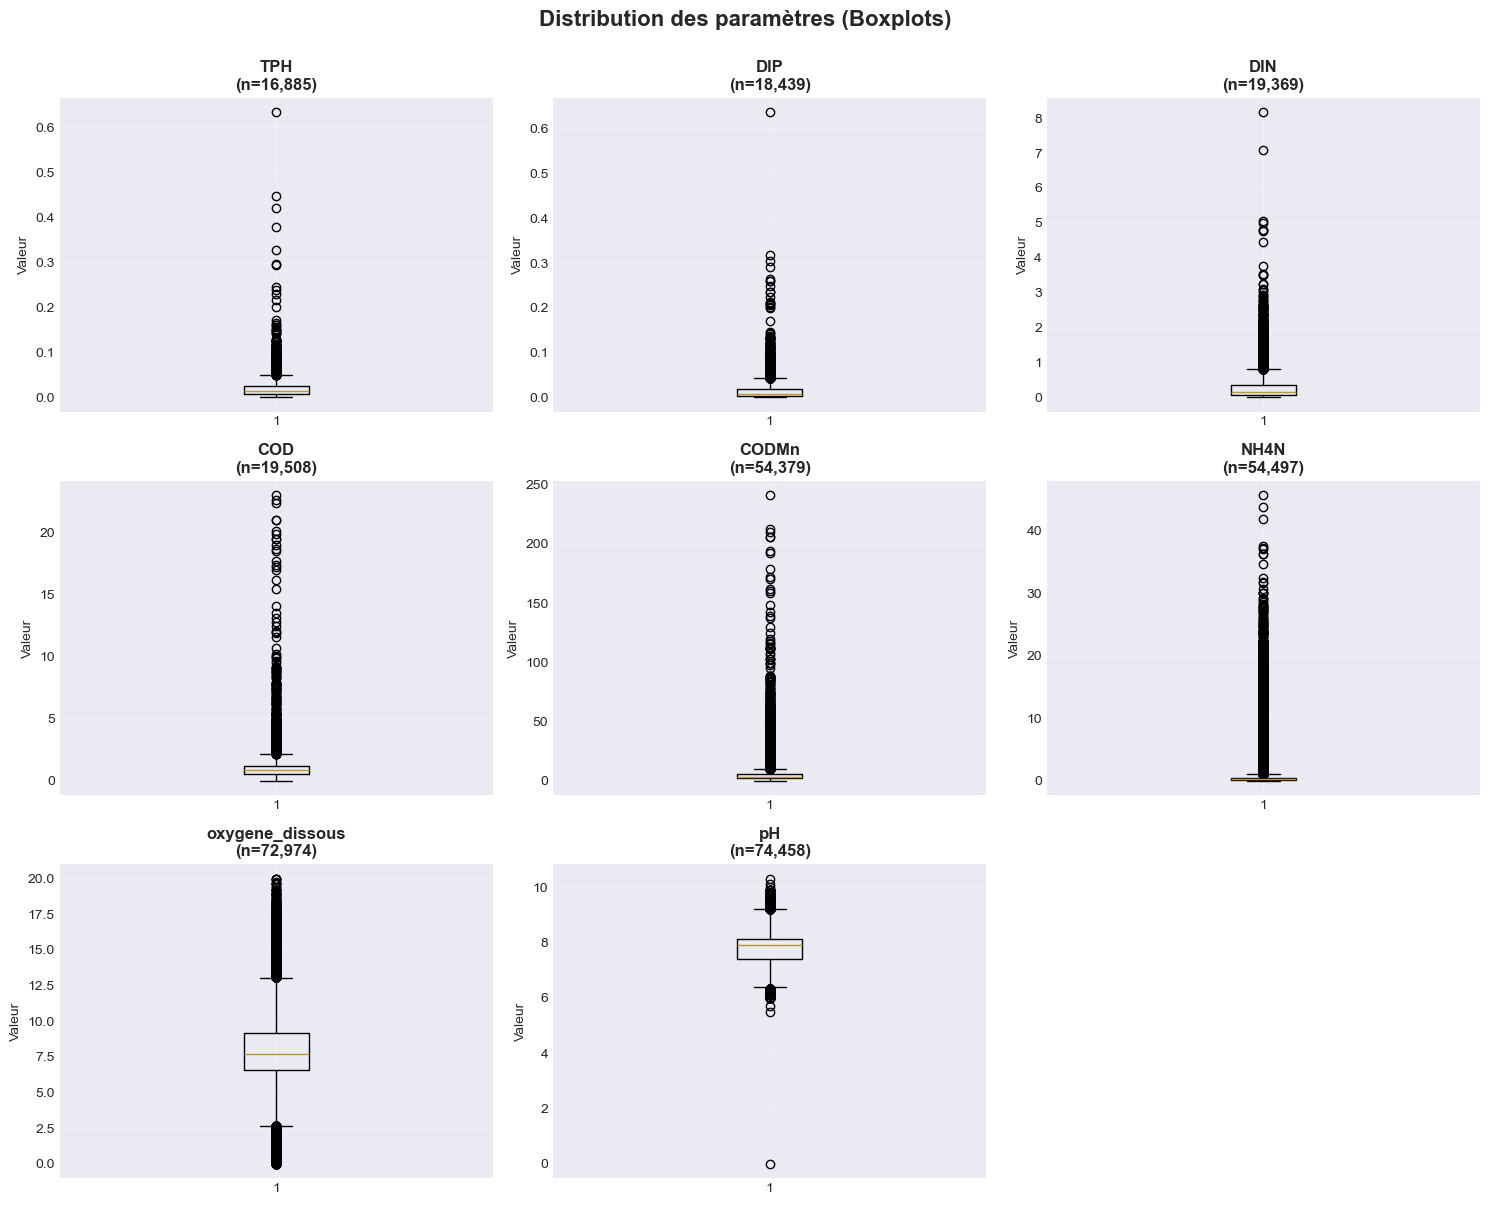

In [12]:
# Créer des boxplots pour visualiser distributions
# Boxplot montre : médiane, quartiles, outliers

n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # 3 graphiques par ligne

fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for i, col in enumerate(numeric_cols):
    if col in df_clean.columns:
        # Retirer NaN pour le graphique
        data = df_clean[col].dropna()
        
        if len(data) > 0:
            axes[i].boxplot(data, vert=True)
            axes[i].set_title(f'{col}\n(n={len(data):,})', fontweight='bold')
            axes[i].set_ylabel('Valeur')
            axes[i].grid(True, alpha=0.3)

# Masquer axes vides
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution des paramètres (Boxplots)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 🔄 9. Gérer les valeurs manquantes restantes

**Stratégies** :
1. **Supprimer lignes** avec trop de NaN (>50% des colonnes)
2. **Interpolation temporelle** : Estimer valeur entre deux mesures
3. **Remplir avec médiane** : Pour valeurs isolées manquantes

In [13]:
print("🔄 Gestion des valeurs manquantes...")
print("="*80)

# Étape 1 : Supprimer lignes avec >50% de colonnes manquantes
nb_cols_utiles = len(numeric_cols)  # Nombre colonnes importantes
threshold_drop = nb_cols_utiles * 0.5  # 50% des colonnes

# Compter NaN par ligne (seulement colonnes numériques importantes)
nan_per_row = df_clean[numeric_cols].isnull().sum(axis=1)
rows_to_drop = nan_per_row > threshold_drop

print(f"Étape 1 : Supprimer lignes avec >{threshold_drop:.0f} colonnes manquantes")
print(f"  → {rows_to_drop.sum():,} lignes supprimées")

df_clean = df_clean[~rows_to_drop].copy()
print(f"  → {len(df_clean):,} lignes restantes")
print()

# Étape 2 : Convertir date en datetime pour interpolation temporelle
print("Étape 2 : Préparation pour interpolation temporelle")
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean = df_clean.sort_values(['station_id', 'date'])
print("  → Dates converties et triées par station + date")
print()

# Étape 3 : Interpolation temporelle par station
print("Étape 3 : Interpolation temporelle (par station)")
print("  Cela peut prendre 1-2 minutes...")

# Pour chaque station, interpoler les valeurs
for col in numeric_cols:
    if col in df_clean.columns:
        nan_avant = df_clean[col].isnull().sum()
        
        # Interpolation linéaire par groupe de station
        df_clean[col] = df_clean.groupby('station_id')[col].transform(
            lambda x: x.interpolate(method='linear', limit_direction='both')
        )
        
        nan_apres = df_clean[col].isnull().sum()
        nan_remplis = nan_avant - nan_apres
        
        if nan_remplis > 0:
            print(f"  • {col:20s}: {nan_remplis:6,} valeurs interpolées")

print()

# Étape 4 : Remplir valeurs restantes avec médiane
print("Étape 4 : Remplir valeurs restantes avec médiane")
for col in numeric_cols:
    if col in df_clean.columns:
        nan_avant = df_clean[col].isnull().sum()
        
        if nan_avant > 0:
            mediane = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(mediane)
            print(f"  • {col:20s}: {nan_avant:6,} valeurs → médiane ({mediane:.2f})")

print()
print("✅ Gestion des valeurs manquantes terminée !")
print(f"📊 Dataset final : {len(df_clean):,} lignes × {len(df_clean.columns)} colonnes")

🔄 Gestion des valeurs manquantes...
Étape 1 : Supprimer lignes avec >4 colonnes manquantes
  → 2,695 lignes supprimées
  → 73,052 lignes restantes

Étape 2 : Préparation pour interpolation temporelle
  → Dates converties et triées par station + date

Étape 3 : Interpolation temporelle (par station)
  Cela peut prendre 1-2 minutes...
  • TPH                 :  2,409 valeurs interpolées
  • TPH                 :  2,409 valeurs interpolées
  • DIP                 :    902 valeurs interpolées
  • DIP                 :    902 valeurs interpolées
  • COD                 :     91 valeurs interpolées
  • COD                 :     91 valeurs interpolées
  • oxygene_dissous     :     52 valeurs interpolées
  • oxygene_dissous     :     52 valeurs interpolées
  • pH                  :      1 valeurs interpolées

Étape 4 : Remplir valeurs restantes avec médiane
  • TPH                 : 53,761 valeurs → médiane (0.01)
  • DIP                 : 53,721 valeurs → médiane (0.01)
  • DIN               

In [14]:
# Vérifier qu'il ne reste plus de NaN
print("🔍 VÉRIFICATION FINALE - Valeurs manquantes :")
print("="*80)
nan_final = df_clean.isnull().sum()
if nan_final.sum() == 0:
    print("✅ Aucune valeur manquante ! Dataset complet.")
else:
    print("⚠️ Valeurs manquantes restantes :")
    print(nan_final[nan_final > 0])

🔍 VÉRIFICATION FINALE - Valeurs manquantes :
✅ Aucune valeur manquante ! Dataset complet.


## 🎯 10. Calculer le score de qualité de l'eau

**Objectif** : Créer une variable cible (target) pour le modèle

**Méthode** : Basé sur normes OMS (Organisation Mondiale de la Santé)

**Score de 0 à 10** :
- **8-10** : EXCELLENTE
- **6-8** : BONNE
- **4-6** : MOYENNE
- **0-4** : MAUVAISE

In [15]:
def calculer_qualite(row):
    """
    Calcule score de qualité (0-10) basé sur normes OMS
    
    Paramètres pris en compte :
    - pH : optimal entre 6.5 et 8.5
    - Température : optimal < 25°C
    - Oxygène dissous : > 6 mg/L
    - Turbidité : < 5 NTU
    - COD : < 20 mg/L (si disponible)
    """
    score = 10  # Score parfait au départ
    
    # pH (poids: 30%)
    if 'pH' in row.index and pd.notna(row['pH']):
        if row['pH'] < 6.5 or row['pH'] > 8.5:
            score -= 3
        elif row['pH'] < 6.0 or row['pH'] > 9.0:
            score -= 5  # Très mauvais
    
    # Température (poids: 20%)
    if 'temperature' in row.index and pd.notna(row['temperature']):
        if row['temperature'] > 25:
            score -= 2
        if row['temperature'] > 30:
            score -= 1  # Très chaud
    
    # Oxygène dissous (poids: 30%)
    if 'oxygene_dissous' in row.index and pd.notna(row['oxygene_dissous']):
        if row['oxygene_dissous'] < 6:
            score -= 3
        if row['oxygene_dissous'] < 4:
            score -= 2  # Très faible
    
    # Turbidité (poids: 10%)
    if 'turbidite' in row.index and pd.notna(row['turbidite']):
        if row['turbidite'] > 5:
            score -= 1
        if row['turbidite'] > 25:
            score -= 1  # Très trouble
    
    # COD - Chemical Oxygen Demand (poids: 10%)
    if 'COD' in row.index and pd.notna(row['COD']):
        if row['COD'] > 20:
            score -= 1
        if row['COD'] > 40:
            score -= 1  # Très pollué
    
    # CODMn - alternative à COD
    elif 'CODMn' in row.index and pd.notna(row['CODMn']):
        if row['CODMn'] > 10:
            score -= 1
        if row['CODMn'] > 20:
            score -= 1
    
    # S'assurer que le score reste entre 0 et 10
    return max(0, min(10, score))


def categoriser_qualite(score):
    """
    Convertit score numérique en catégorie
    """
    if score >= 8:
        return "EXCELLENTE"
    elif score >= 6:
        return "BONNE"
    elif score >= 4:
        return "MOYENNE"
    else:
        return "MAUVAISE"


print("🎯 Calcul du score de qualité...")
print("="*80)

# Appliquer la fonction à chaque ligne
df_clean['quality_score'] = df_clean.apply(calculer_qualite, axis=1)
df_clean['quality_category'] = df_clean['quality_score'].apply(categoriser_qualite)

print("✅ Score de qualité calculé !")
print()

# Statistiques des scores
print("📊 DISTRIBUTION DES SCORES DE QUALITÉ :")
print("="*80)
print(df_clean['quality_score'].describe().round(2))
print()

print("📊 DISTRIBUTION DES CATÉGORIES :")
print("="*80)
cat_counts = df_clean['quality_category'].value_counts()
cat_percent = (cat_counts / len(df_clean) * 100).round(1)
for cat in ['EXCELLENTE', 'BONNE', 'MOYENNE', 'MAUVAISE']:
    if cat in cat_counts.index:
        print(f"  {cat:12s}: {cat_counts[cat]:6,} ({cat_percent[cat]:5.1f}%)")

🎯 Calcul du score de qualité...
✅ Score de qualité calculé !

📊 DISTRIBUTION DES SCORES DE QUALITÉ :
count    73052.00
mean         9.31
std          1.48
min          2.00
25%         10.00
50%         10.00
75%         10.00
max         10.00
Name: quality_score, dtype: float64

📊 DISTRIBUTION DES CATÉGORIES :
  EXCELLENTE  : 58,854 ( 80.6%)
  BONNE       : 10,521 ( 14.4%)
  MOYENNE     :  3,541 (  4.8%)
  MAUVAISE    :    136 (  0.2%)
✅ Score de qualité calculé !

📊 DISTRIBUTION DES SCORES DE QUALITÉ :
count    73052.00
mean         9.31
std          1.48
min          2.00
25%         10.00
50%         10.00
75%         10.00
max         10.00
Name: quality_score, dtype: float64

📊 DISTRIBUTION DES CATÉGORIES :
  EXCELLENTE  : 58,854 ( 80.6%)
  BONNE       : 10,521 ( 14.4%)
  MOYENNE     :  3,541 (  4.8%)
  MAUVAISE    :    136 (  0.2%)


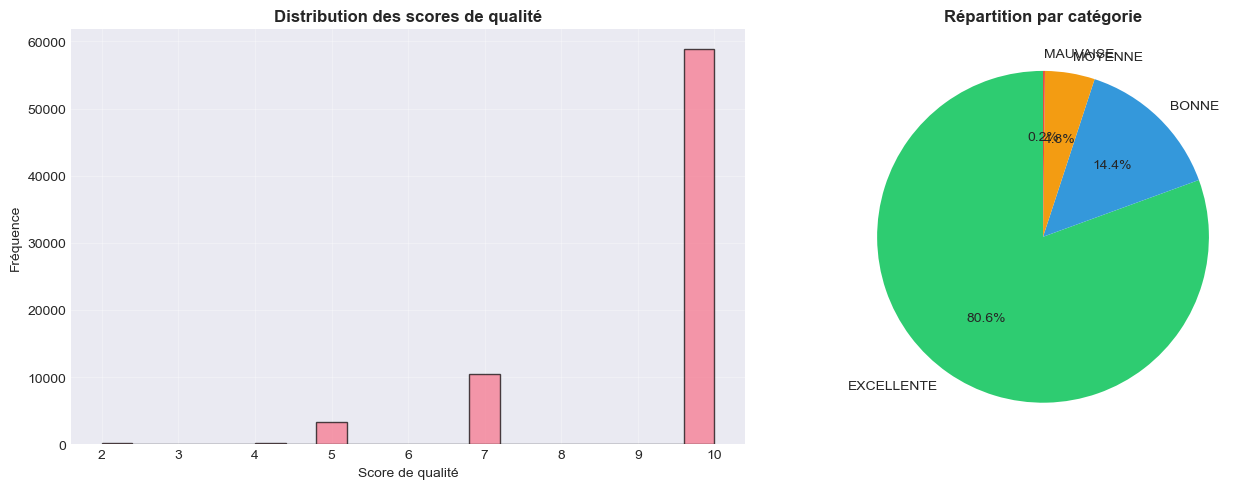

In [16]:
# Visualisations des scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des scores
axes[0].hist(df_clean['quality_score'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Score de qualité')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des scores de qualité', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Diagramme circulaire des catégories
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
cat_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_ylabel('')
axes[1].set_title('Répartition par catégorie', fontweight='bold')

plt.tight_layout()
plt.show()

## 💾 11. Sauvegarder le dataset nettoyé

**Fichier de sortie** : `data/processed/capteurs_cleaned.csv`

**Ce fichier sera utilisé pour** :
1. Fusion avec données satellites
2. Entraînement du modèle ML

In [17]:
# Créer dossier processed s'il n'existe pas
import os
os.makedirs('../data/processed', exist_ok=True)

# Sauvegarder
output_path = '../data/processed/capteurs_cleaned.csv'
df_clean.to_csv(output_path, index=False)

print("💾 Dataset nettoyé sauvegardé !")
print("="*80)
print(f"📁 Fichier : {output_path}")
print(f"📊 Taille : {len(df_clean):,} lignes × {len(df_clean.columns)} colonnes")
print(f"💽 Poids : {os.path.getsize(output_path) / 1024**2:.2f} MB")
print()

# Résumé final
print("✅ RÉSUMÉ FINAL :")
print("="*80)
print(f"Colonnes principales :")
print(f"  • Métadonnées : station_id, date, latitude, longitude")
print(f"  • Paramètres : {', '.join([col for col in df_clean.columns if col in numeric_cols])}")
print(f"  • Target : quality_score, quality_category")
print()
print(f"Qualité des données :")
print(f"  • Valeurs manquantes : {df_clean.isnull().sum().sum()}")
print(f"  • Valeurs aberrantes : Nettoyées")
print(f"  • Prêt pour ML : ✅ OUI")

💾 Dataset nettoyé sauvegardé !
📁 Fichier : ../data/processed/capteurs_cleaned.csv
📊 Taille : 73,052 lignes × 14 colonnes
💽 Poids : 6.26 MB

✅ RÉSUMÉ FINAL :
Colonnes principales :
  • Métadonnées : station_id, date, latitude, longitude
  • Paramètres : TPH, DIP, DIN, COD, CODMn, NH4N, oxygene_dissous, pH
  • Target : quality_score, quality_category

Qualité des données :
  • Valeurs manquantes : 0
  • Valeurs aberrantes : Nettoyées
  • Prêt pour ML : ✅ OUI


## 🎯 PROCHAINES ÉTAPES

### ✅ Ce qui est fait :
1. ✅ Données chargées
2. ✅ Format transformé (long → large)
3. ✅ Valeurs aberrantes nettoyées
4. ✅ Valeurs manquantes traitées
5. ✅ Score qualité calculé
6. ✅ Dataset sauvegardé

### 📋 Prochaines étapes :
1. **Télécharger données satellites** (Sentinel-2)
2. **Fusionner capteurs + satellites**
3. **Normaliser les données** (0-1)
4. **Créer séquences temporelles** (24h)
5. **Entraîner modèle LSTM**

---

**Fichier créé** : `data/processed/capteurs_cleaned.csv` 🎉